# Simple Transformer based Multi-Class Classifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
import os
import re

import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras

### Build Base Layer

In [ ]:
encoder_model = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
hub_layer = hub.KerasLayer(encoder_model, input_shape=[], dtype = tf.string, trainable = True)

###Build Model

In [ ]:
my_model = keras.Sequential()
my_model.add(hub_layer)
my_model.add(keras.layers.Dense(255, activation = 'relu'))
my_model.add(keras.layers.Dropout(0.2))
my_model.add(keras.layers.Dense(64, activation = 'relu'))
my_model.add(keras.layers.Dense(3))

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 255)               130815    
                                                                 
 dropout (Dropout)           (None, 255)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16384     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 256945218 (980.17 MB)
Trainable params: 256945218 (980.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###Load Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DATASETS/UglyWords1.csv")

In [ ]:
data

,string,Emotion,Caution
0,*screams in 25 different languages*,0,-1
1,Families to sue over Legionnaires: More than 4...,-1,0
2,Pandemonium In Aba As Woman Delivers Baby With...,0,0
3,My emotions are a train wreck. My body is a tr...,-1,-1
4,Alton brown just did a livestream and he burne...,0,0
...,...,...,...
1859,@Trollkrattos Juan Carlos Salvador The Secret ...,-2,-1
1860,@devon_breneman hopefully it doesn't electrocu...,0,1
1861,Businesses are deluged with invokces. Make you...,-2,-1
1862,#BREAKING411 4 police officers arrested for ab...,-1,1


###Data-Preprocess

In [ ]:
tweet = data['string'].to_numpy()
labels = data['Emotion'].map({-2:0,-1:1,0:2,1:3,2:4})
labels1 = data['Caution'].map({-1:0, 0:1, 1:2})

In [ ]:
tweet

array(['*screams in 25 different languages*',
       "Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/ZA4AXFJSVB",
       'Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/c5u9qshhnb',
       ...,
       "Businesses are deluged with invokces. Make yours stand out with colour or shape.and it's likely to rise to the top of the pay' pile.",
       '#BREAKING411 4 police officers arrested for abusing children at police-run boot camp in San Luis Obispo Calif. - ... http://t.co/oNLvf2fyoY',
       '@News@ Refugio oil spill may have been costlier bigger than projected http://t.co/SqoA1Wv4Um'],
      dtype=object)

(array([385.,   0.,   0.,   0.,   0., 753.,   0.,   0.,   0., 726.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

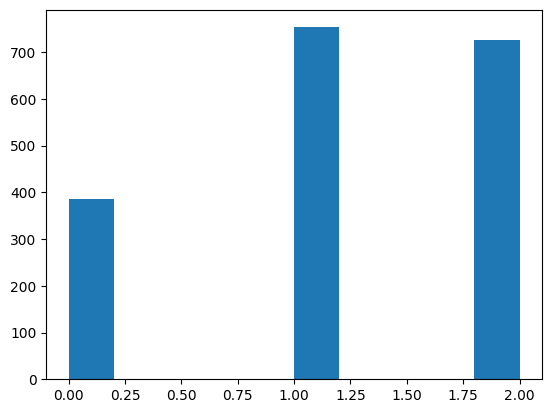

In [ ]:
plt.figure()
plt.hist(labels1)

In [ ]:
data['Caution'] = data['Caution'].map({-1:0, 0:1, 1:2})

In [ ]:
print(data['Caution'].value_counts())

Caution
1    753
2    726
0    385
Name: count, dtype: int64


In [ ]:
max_count = data['Caution'].value_counts().max()

In [ ]:
upsampled_list = []

In [ ]:
for Caution in data['Caution'].unique():
    subset = data[data['Caution'] == Caution]
    upsampled = subset.sample(n=max_count, replace=True, random_state=42)
    upsampled_list.append(upsampled)

In [ ]:
data_upsampled = pd.concat(upsampled_list).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(data_upsampled['Caution'].value_counts())

Caution
2    753
0    753
1    753
Name: count, dtype: int64


In [ ]:
data_upsampled

,string,Emotion,Caution
0,"Still , this flick is fun , and host to some t...",2,2
1,@thebriankrause leos ass just got metaphorical...,-1,0
2,@Trollkrattos Juan Carlos Salvador The Secret ...,-2,0
3,While The Isle is both preposterous and thorou...,2,2
4,Mmmmmm I'm burning.... I'm burning buildings I...,-2,0
...,...,...,...
2254,"Day is not a great Bond movie , but it is a go...",1,2
2255,"Like most Bond outings in recent years , some ...",-1,1
2256,and I thought my surgical wounds were healed!!...,-1,1
2257,RT @calestous: Tanzania elephant population de...,0,1


(array([753.,   0.,   0.,   0.,   0., 753.,   0.,   0.,   0., 753.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

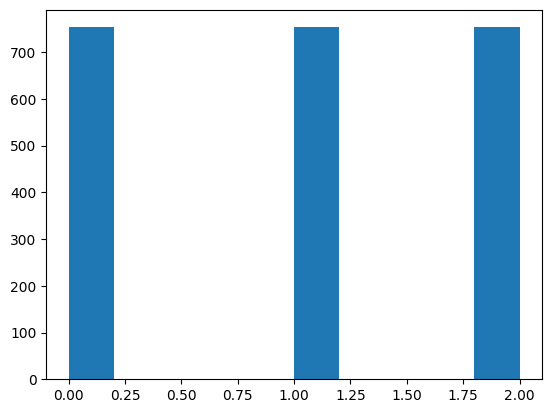

In [ ]:
plt.figure()
plt.hist(data_upsampled['Caution'])

In [ ]:
data['Emotion'] = data['Emotion'].map({-2:0,-1:1,0:2,1:3,2:4})

(array([100.,   0., 509.,   0.,   0., 849.,   0., 356.,   0.,  50.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

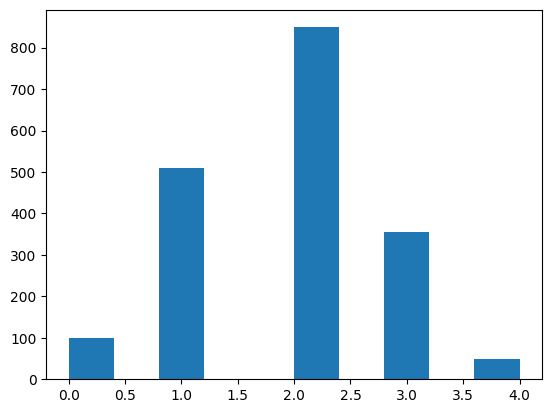

In [ ]:
plt.figure()
plt.hist(labels)

In [ ]:
def train_test(df, train,validate, test):
  from sklearn.model_selection import train_test_split
  df=df.sample(frac=1)
  train_data, temp_data= train_test_split(df, test_size=(1-train))
  test_data, validation_data = train_test_split(temp_data, test_size=(validate/(test+validate)))

  return train_data,validation_data,test_data

In [ ]:
def process_tensor(df,data_col_name,labels_col_name):
  try:
    df =df.drop(columns='Date')
  except: pass

  train_tensor = tf.convert_to_tensor(df[data_col_name])
  train_labels_tensor = tf.convert_to_tensor(keras.utils.to_categorical(df[labels_col_name]))

  return [train_tensor, train_labels_tensor]

In [ ]:
train_data, validation_data, test_data = train_test(data_upsampled, 0.7, 0.15, 0.15)

In [ ]:
train_data

,string,Emotion,Caution
1048,No better feeling than seeing and being on sta...,1,2
598,ÛÏ@based_georgie: yo forreal we need to have ...,-1,2
127,Watch This Airport Get Swallowed Up By A Sands...,-1,0
1830,Lead provocatuers Testud and Parmentier give s...,0,1
250,#Biztip We recommend all businesses to get an ...,1,2
...,...,...,...
592,that horrible sinking feeling when youÛªve be...,0,1
1219,Families to sue over Legionnaires: More than 4...,-1,1
619,"A somewhat crudely constructed but gripping , ...",0,1
898,FedEx no longer will ship potential bioterror ...,0,1


In [ ]:
train_tensor = process_tensor(train_data, 'string', 'Caution')
validate_tensor = process_tensor(validation_data, 'string', 'Caution')
test_tensor = process_tensor(test_data, 'string', 'Caution')

In [ ]:
train_tensor

[<tf.Tensor: shape=(1581,), dtype=string, numpy=
 array([b'No better feeling than seeing and being on stage with my day ones...... 22 year friendships and we still body bagging mics together.',
        b'\xc2\x89\xc3\x9b\xc3\x8f@based_georgie: yo forreal we need to have like an emergency action plan incase donald trump becomes president\xc2\x89\xc3\x9b\xc2\x9d\nWhipe that lil baby',
        b'Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/1tr2KvXCTW',
        ...,
        b'A somewhat crudely constructed but gripping , questing look at a person so racked with self-loathing , he becomes an enemy to his own race .',
        b'FedEx no longer will ship potential bioterror pathogens - FedEx Corp. (NYSE: FDX) will no longer deliver packages ... http://t.co/2kdq56xTWs',
        b'Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/I4AogcSOY5 http://t.co/dJIwG9pxV4'],
       dtype=object)>,
 <tf.Tensor: shape=(1

In [ ]:
my_model.compile(optimizer="Nadam", loss=keras.losses.CategoricalFocalCrossentropy(from_logits= True), metrics = ['categorical_accuracy'])

In [ ]:
history = my_model.fit(train_tensor[0], y=train_tensor[1], epochs =10, validation_data=validate_tensor, verbose = 1)

Epoch 1/10
50/50 [==============================] - 161s 2s/step - loss: 0.1046 - categorical_accuracy: 0.5515 - val_loss: 0.0868 - val_categorical_accuracy: 0.6283
Epoch 2/10
50/50 [==============================] - 29s 591ms/step - loss: 0.0469 - categorical_accuracy: 0.8248 - val_loss: 0.0684 - val_categorical_accuracy: 0.7257
Epoch 3/10
50/50 [==============================] - 17s 339ms/step - loss: 0.0118 - categorical_accuracy: 0.9602 - val_loss: 0.0825 - val_categorical_accuracy: 0.7493
Epoch 4/10
50/50 [==============================] - 15s 299ms/step - loss: 0.0048 - categorical_accuracy: 0.9817 - val_loss: 0.0831 - val_categorical_accuracy: 0.7729
Epoch 5/10
50/50 [==============================] - 11s 227ms/step - loss: 0.0022 - categorical_accuracy: 0.9911 - val_loss: 0.0999 - val_categorical_accuracy: 0.7493
Epoch 6/10
50/50 [==============================] - 9s 191ms/step - loss: 0.0018 - categorical_accuracy: 0.9899 - val_loss: 0.1047 - val_categorical_accuracy: 0.7552
E

In [ ]:
results = my_model.evaluate(test_tensor[0], test_tensor[1], verbose=2)

11/11 - 0s - loss: 0.1260 - categorical_accuracy: 0.7463 - 117ms/epoch - 11ms/step


### On Emotion


In [ ]:
data

,string,Emotion,Caution
0,*screams in 25 different languages*,2,0
1,Families to sue over Legionnaires: More than 4...,1,1
2,Pandemonium In Aba As Woman Delivers Baby With...,2,1
3,My emotions are a train wreck. My body is a tr...,1,0
4,Alton brown just did a livestream and he burne...,2,1
...,...,...,...
1859,@Trollkrattos Juan Carlos Salvador The Secret ...,0,0
1860,@devon_breneman hopefully it doesn't electrocu...,2,2
1861,Businesses are deluged with invokces. Make you...,0,0
1862,#BREAKING411 4 police officers arrested for ab...,1,2


In [ ]:
data_upsampled

,string,Emotion,Caution
0,"Still , this flick is fun , and host to some t...",2,2
1,@thebriankrause leos ass just got metaphorical...,-1,0
2,@Trollkrattos Juan Carlos Salvador The Secret ...,-2,0
3,While The Isle is both preposterous and thorou...,2,2
4,Mmmmmm I'm burning.... I'm burning buildings I...,-2,0
...,...,...,...
2254,"Day is not a great Bond movie , but it is a go...",1,2
2255,"Like most Bond outings in recent years , some ...",-1,1
2256,and I thought my surgical wounds were healed!!...,-1,1
2257,RT @calestous: Tanzania elephant population de...,0,1


In [ ]:
print(data['Emotion'].value_counts())

Emotion
2    849
1    509
3    356
0    100
4     50
Name: count, dtype: int64


In [ ]:
max_emotion_count = data['Emotion'].value_counts().max()

In [ ]:
upsampled_emotion_list = []

In [ ]:
for Emotion in data['Emotion'].unique():
    subset = data[data['Emotion'] == Emotion]
    upsampled_emotion = subset.sample(n=max_count, replace=True, random_state=42)
    upsampled_emotion_list.append(upsampled_emotion)

In [ ]:
data_emotion_upsampled = pd.concat(upsampled_emotion_list).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(data_emotion_upsampled['Emotion'].value_counts())

Emotion
0    753
3    753
2    753
4    753
1    753
Name: count, dtype: int64


(array([160.,   0., 705.,   0.,   0., 944.,   0., 390.,   0.,  60.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <BarContainer object of 10 artists>)

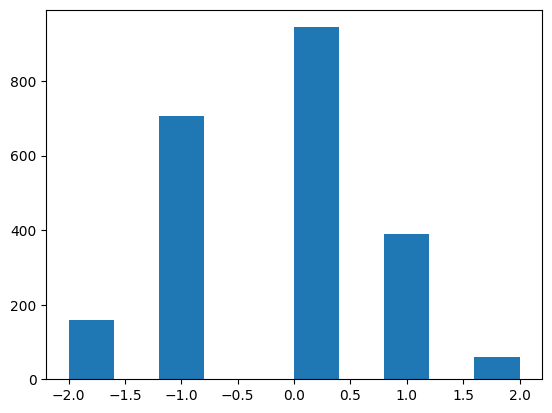

In [ ]:
plt.figure()
plt.hist(data_upsampled['Emotion'])

(array([753.,   0., 753.,   0.,   0., 753.,   0., 753.,   0., 753.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

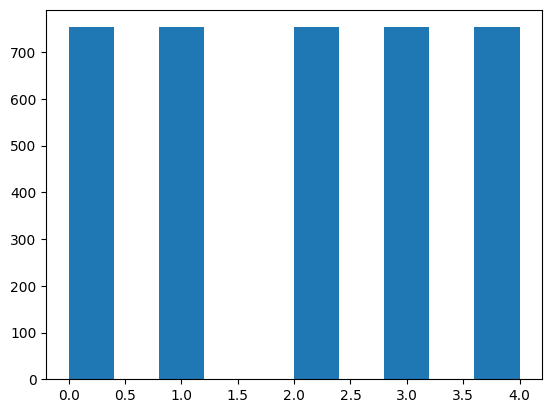

In [ ]:
plt.figure()
plt.hist(data_emotion_upsampled['Emotion'])

In [ ]:
train_emotion_data, validation_emotion_data, test_emotion_data = train_test(data_emotion_upsampled, 0.7, 0.15, 0.15)

In [ ]:
train_tensor_emotion = process_tensor(train_emotion_data, 'string', 'Emotion')
validate_tensor_emotion = process_tensor(validation_emotion_data, 'string', 'Emotion')
test_tensor_emotion = process_tensor(test_emotion_data, 'string', 'Emotion')

In [ ]:
train_tensor_emotion

[<tf.Tensor: shape=(2635,), dtype=string, numpy=
 array([b"We know this is bad for the bees - don't give in to pressure from short term profit obsessed chemical companies... http://t.co/aNuTOopKF4",
        b"Those outside show business will enjoy a close look at people they do n't really want to know .",
        b'Beastin Tapas this evening with some good folk! #funtimes #demolished http://t.co/JxUEPkmkRh',
        ...,
        b"The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
        b"@heebsterrr_ I remember the heat wave the year I went bruh and they don't have AC ????",
        b'South Sac I5 S / I5 S 43rd Ave Ofr **Trfc Collision-No Inj** http://t.co/GpxQBYzYu4'],
       dtype=object)>,
 <tf.Tensor: shape=(2635, 5), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1

In [ ]:
encoder_model = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
hub_layer = hub.KerasLayer(encoder_model, input_shape=[], dtype = tf.string, trainable = True)

In [ ]:
my_model_emotion = keras.Sequential()
my_model_emotion.add(hub_layer)
my_model_emotion.add(keras.layers.Dense(255, activation = 'relu'))
my_model_emotion.add(keras.layers.Dropout(0.2))
my_model_emotion.add(keras.layers.Dense(64, activation = 'relu'))
my_model_emotion.add(keras.layers.Dense(5))

In [ ]:
my_model_emotion.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 255)               130815    
                                                                 
 dropout_1 (Dropout)         (None, 255)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16384     
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256945348 (980.17 MB)
Trainable params: 256945348 (980.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
my_model_emotion.compile(optimizer="Nadam", loss=keras.losses.CategoricalCrossentropy(from_logits= True), metrics = ['categorical_accuracy'])

In [ ]:
history_emotion = my_model_emotion.fit(train_tensor_emotion[0], y=train_tensor_emotion[1], epochs =10, validation_data=validate_tensor_emotion, verbose = 1)

Epoch 1/10
83/83 [==============================] - 143s 1s/step - loss: 1.1280 - categorical_accuracy: 0.5529 - val_loss: 0.5773 - val_categorical_accuracy: 0.7805
Epoch 2/10
83/83 [==============================] - 25s 300ms/step - loss: 0.2963 - categorical_accuracy: 0.9131 - val_loss: 0.3751 - val_categorical_accuracy: 0.8726
Epoch 3/10
83/83 [==============================] - 19s 223ms/step - loss: 0.0713 - categorical_accuracy: 0.9803 - val_loss: 0.4053 - val_categorical_accuracy: 0.8867
Epoch 4/10
83/83 [==============================] - 13s 152ms/step - loss: 0.0395 - categorical_accuracy: 0.9894 - val_loss: 0.4771 - val_categorical_accuracy: 0.8920
Epoch 5/10
83/83 [==============================] - 14s 169ms/step - loss: 0.0191 - categorical_accuracy: 0.9951 - val_loss: 0.4395 - val_categorical_accuracy: 0.8867
Epoch 6/10
83/83 [==============================] - 12s 141ms/step - loss: 0.0116 - categorical_accuracy: 0.9962 - val_loss: 0.5004 - val_categorical_accuracy: 0.8903


In [ ]:
results = my_model_emotion.evaluate(test_tensor_emotion[0], test_tensor_emotion[1], verbose=2)

18/18 - 0s - loss: 0.4305 - categorical_accuracy: 0.9186 - 171ms/epoch - 9ms/step


In [ ]:
def classify_emotion(text, nlp_model):
    label_map = {0: "Very Sad", 1: "Sad", 2: "Neutral", 3: "Happy", 4:"Very Happy"}
    prediction = nlp_model.predict([text], verbose=0)
    predicted_class = prediction.argmax(axis=-1)[0]
    return f"Predicted Emotion: {label_map[predicted_class]}"

In [ ]:
classify_emotion("The ", my_model_emotion)

In [ ]:
def classify_Caution(text, nlp_model):
    label_map = {0: "Toxic", 1: "Cautious", 2: "Safe"}
    prediction = nlp_model.predict([text], verbose=0)
    predicted_class = prediction.argmax(axis=-1)[0]
    return f"Predicted Sentiment: {label_map[predicted_class]}"

In [ ]:
classify_Caution("I explained my hurt and got blamed", my_model)